# generate the y
## format : (x,y,w,h)

In [1]:
from keras.preprocessing import image
import numpy as np
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
%matplotlib inline 
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

Using TensorFlow backend.


In [2]:
# anno_file = "/Users/xuan/work/dataset/Annotation/n02085620-Chihuahua/n02085620_1346"
# image_file = "/Users/xuan/work/dataset/dogs/n02085620/n02085620_1346.JPEG"

In [2]:
def get_image_size(af):
    tree = ET.parse(af)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    image_size_el = tree.getroot().find("size")
    return (float(image_size_el.find("width").text), float(image_size_el.find("height").text))

In [3]:
# from anno file into y vector
# todo: should consider the target image size
def anno_file_to_y(af):
    tree = ET.parse(af)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    image_size_el = tree.getroot().find("size")
    image_width = float(image_size_el.find("width").text)
    image_height = float(image_size_el.find("height").text)
    
    rect = [(float(box.find("xmin").text), 
          float(box.find("ymin").text), 
          float(box.find("xmax").text), 
          float(box.find("ymax").text)) for box in boxes][0]
    width = (rect[2] - rect[0]) / image_width
    height = (rect[3] - rect[1]) / image_height
    center_x = (rect[2] + rect[0]) / (2. * image_width)
    center_y = (rect[3] + rect[1]) / (2. * image_height)
    return (center_x, center_y ,width, height)

In [4]:
# show the bound box
def anno_file_to_rect(anno_file):
    tree = ET.parse(anno_file)
    objs = tree.getroot().findall("object")
    boxes = [obj.find("bndbox") for obj in objs]
    return [(int(box.find("xmin").text), 
              int(box.find("ymin").text), 
              int(box.find("xmax").text), 
              int(box.find("ymax").text)) for box in boxes][0]

In [5]:
# random one image
idx = np.random.randint(0, 100)
print idx
anno_dir = "/Users/xuan/work/dataset/Annotation/n02085620-Chihuahua"
img_dir = "/Users/xuan/work/dataset/dogs/n02085620"
image_file = os.listdir(anno_dir)[idx]
print image_file
anno_file = anno_dir + "/" + image_file
image_file = img_dir + "/" + image_file + ".JPEG"
print "anno & img file as", anno_file, image_file
assert(os.path.exists(anno_file))
assert(os.path.exists(image_file))
# !cat {anno_file}

18
n02085620_14413
anno & img file as /Users/xuan/work/dataset/Annotation/n02085620-Chihuahua/n02085620_14413 /Users/xuan/work/dataset/dogs/n02085620/n02085620_14413.JPEG


/Library/Python/2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


truth rect (142, 123, 546, 850)
image width & height 640.0 853.0
calc cy, cy, h, w 0.5375 0.570339976553 0.852286049238 0.63125
calced as (142.0, 122.99999999999999, 404.0, 727.0)


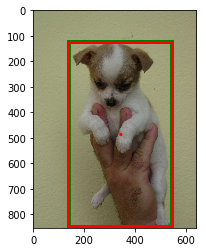

In [6]:
# print some example
_, ax = plt.subplots(1)
ax.imshow(imread(image_file))

## truth bound box
rect = anno_file_to_rect(anno_file)
patch = patches.Rectangle((rect[0],rect[1]),rect[2] - rect[0],rect[3] - rect[1],linewidth=4,edgecolor='g',facecolor='none')
ax.add_patch(patch)
print "truth rect", rect

## but calced as
(image_width, image_height) = get_image_size(anno_file)
(cx, cy, w, h) = anno_file_to_y(anno_file)
print "image width & height", image_width, image_height
print "calc cy, cy, h, w", cx, cy, h, w
# draw in image

rect = ((cx - (w / 2.0)) * image_width, (cy - (h/2.0)) * image_height, w * image_width, h * image_height)
print "calced as", rect
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(patch)
patch = patches.Circle((cx * image_width, cy * image_height), 4, linewidth=1,color='r',fill='full')
ax.add_patch(patch)

plt.show()

In [69]:
## generate X, y from images and annotation dir
JPEG_EXT = "JPEG"
flatten = lambda l: [item for sublist in l for item in sublist]

class YoloDataGenerator(object):
    'Generates image yolo from dataset'
    def __init__(self, image_dir, annotation_dir, batch_size = 16, target_size = (224, 224)):
        'Initialization'
        self.image_dir = image_dir # image id list
        self.annotation_dir = annotation_dir
        ids = []
        for clz in os.listdir(annotation_dir):
            ids.append([clz + "/" + f for f in os.listdir(annotation_dir + "/" + clz)])
        self.ids = flatten(ids)
        self.steps = 0
        self.batch_size = batch_size
        self.target_size = target_size

    def generate(self):
        while self.steps < len(self.ids) // self.batch_size:
            ids = self.ids[self.steps * self.batch_size: (self.steps + 1) * self.batch_size]
            image_files = [self.image_dir + "/" + id + "." + JPEG_EXT for id in ids]
            anno_files = [self.annotation_dir + "/" + id for id in ids]
            ys = [anno_file_to_y(af) for af in anno_files]
            xs = [image.img_to_array(image.load_img(image_file,target_size =  self.target_size)) for image_file in image_files]
            print xs[0].shape
            self.steps += 1
            yield np.array(xs, dtype=np.float16), np.array(ys, dtype=np.float16)

In [70]:
# test the generator
yolo_gen = YoloDataGenerator("/Users/xuan/work/dataset/dogs", 
                  "/Users/xuan/work/dataset/Annotation")
generator = yolo_gen.generate()
for x, y in generator:
    print "x & y shape", x.shape, y.shape

print "done"

IOError: [Errno 2] No such file or directory: '/Users/xuan/work/dataset/dogs/n02097658-silky_terrier/n02097658_98.JPEG'